In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint

from py_analyze_tools.sklearn import BasisFunctionConfiguration, ReaDDyElasticNetEstimator

from scipy.integrate import odeint
import numpy as np
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from pathos.multiprocessing import Pool
from sklearn.model_selection import KFold
import itertools

In [2]:
traj = pat.Trajectory("../generate/simple_trajectory_2.h5")
traj.counts = traj.counts[:]
traj.update()

traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[20000:]
traj2.update()

bfc = BasisFunctionConfiguration(n_species=4)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fusion(0, 2, 3)  # A + C -> D
bfc.add_fusion(0, 3, 2)  # A + D -> C
bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_fission(0, 1, 2) # A -> B + C
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D

max counts = 6000.0, min nonzero counts = 1.0
max counts = 4276.0, min nonzero counts = 1724.0


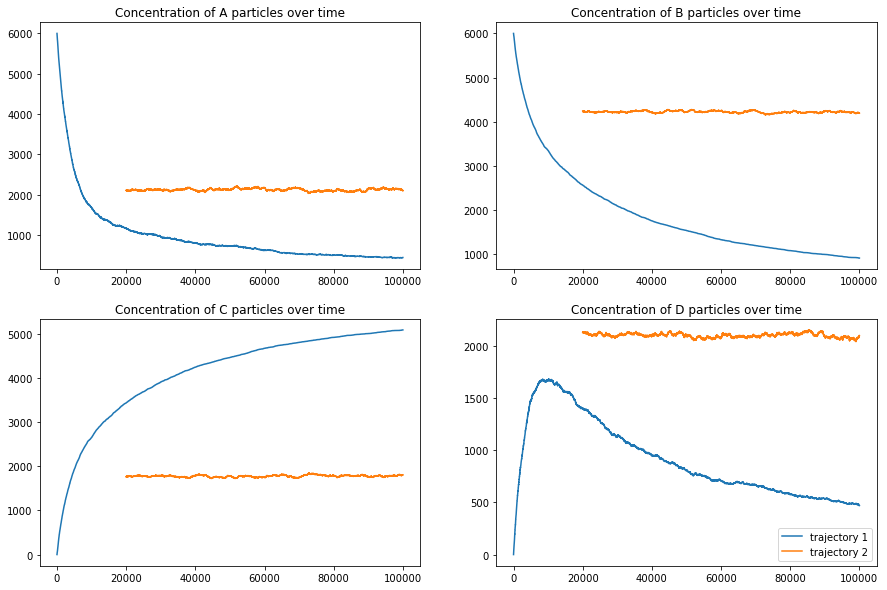

In [3]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps), traj.counts[:,i], label="trajectory 1")
    axes[i].plot(np.arange(0, traj2.n_time_steps)+20000, traj2.counts[:, i], label="trajectory 2")
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

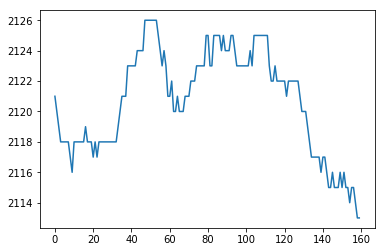

In [4]:
plt.plot(np.arange(0, traj2.n_time_steps//500), traj2.counts[10000:10000+traj2.n_time_steps//500, 0])

# cross validation within trajectory 2 using k-fold

In [6]:
class CVResult(object):
    
    def __init__(self, alpha, l1_ratio, estimator):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.estimator = estimator
        self.scores = []
        
    def add_score(self, score):
        self.scores.append(score)

In [7]:
class CV(object):
    
    def __init__(self, traj, bfc, scale, alphas, l1_ratios, n_splits, init_xi, n_jobs=8, show_progress=True):
        self.alphas = alphas
        self.l1_ratios = l1_ratios
        self.n_jobs = n_jobs
        self.n_splits = n_splits
        self.traj = traj
        self.bfc = bfc
        self.scale = scale
        self.show_progress = show_progress
        self.result = []
        self.init_xi = init_xi
        
    def compute_cv_result(self, params):
        kf = KFold(n_splits=self.n_splits)
        alpha, l1_ratio = params
        estimator = ReaDDyElasticNetEstimator(self.traj, self.bfc, self.scale, alpha=alpha, 
                                              l1_ratio=l1_ratio, init_xi=self.init_xi)
        scores = []
        for train_idx, test_idx in kf.split(range(0, self.traj.n_time_steps)):
            estimator.fit(train_idx)
            scores.append(estimator.score(test_idx, traj2.dcounts_dt[test_idx]))
        return {'scores': scores, 'alpha': alpha, 'l1_ratio': l1_ratio}
        
    def fit(self):
        params = itertools.product(self.alphas, self.l1_ratios)
        result = []
        if self.show_progress:
            from ipywidgets import IntProgress
            from IPython.display import display
            f = IntProgress(min=0, max=len(self.alphas)*len(self.l1_ratios)-1)
            display(f)
        with Pool(processes=self.n_jobs) as p:
            for idx, res in enumerate(p.imap_unordered(self.compute_cv_result, params, 1)):
                result.append(res)
                if self.show_progress:
                    f.value = idx
        f.close()
        self.result = result

In [12]:
def get_dense_params(traj, bfc, scale, n_initial_values=16, n_jobs=8):
    from ipywidgets import IntProgress
    from IPython.display import display
    f = IntProgress(min=1, max=n_initial_values)
    display(f)
    coeffs = []
    initial_values = [np.random.random(bfc.n_basis_functions) for _ in range(n_initial_values)]
    
    def worker(init_xi):
        est = ReaDDyElasticNetEstimator(traj, bfc, scale, alpha=0, l1_ratio=1.0, init_xi=init_xi, verbose=False)
        est.fit(range(0, traj.n_time_steps))
        return est.coefficients_
    
    coeffs = []
    with Pool(processes=n_jobs) as p:
        for idx, coeff in enumerate(p.imap_unordered(worker, initial_values, 1)):
            coeffs.append(coeff)
            f.value = idx+1
    f.close()
    return coeffs

In [28]:
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=5)
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
coeffs = get_dense_params(traj2, bfc, scale, n_jobs=8, n_initial_values=64)

least squares 1 / 64
least squares 2 / 64
least squares 3 / 64
least squares 4 / 64
least squares 5 / 64
least squares 6 / 64
least squares 7 / 64
least squares 8 / 64
least squares 9 / 64
least squares 10 / 64
least squares 11 / 64
least squares 12 / 64
least squares 13 / 64
least squares 14 / 64
least squares 15 / 64
least squares 16 / 64
least squares 17 / 64
least squares 18 / 64
least squares 19 / 64
least squares 20 / 64
least squares 21 / 64
least squares 22 / 64
least squares 23 / 64
least squares 24 / 64
least squares 25 / 64
least squares 26 / 64
least squares 27 / 64
least squares 28 / 64
least squares 29 / 64
least squares 30 / 64
least squares 31 / 64
least squares 32 / 64
least squares 33 / 64
least squares 34 / 64
least squares 35 / 64
least squares 36 / 64
least squares 37 / 64
least squares 38 / 64
least squares 39 / 64
least squares 40 / 64
least squares 41 / 64
least squares 42 / 64
least squares 43 / 64
least squares 44 / 64
least squares 45 / 64
least squares 46 / 

In [29]:
print("estimated coefficients:")

mean, std = np.mean(np.array(coeffs), axis=0), np.std(np.array(coeffs), axis=0)
print("mean=%s" % mean)
print("std=%s" % std)

estimated coefficients:
mean=[  1.83750827e-05   1.65500856e-07   5.46281945e-08   1.42029075e-05
   9.25337325e-02   5.00634680e-02   3.13310466e-04   9.54048258e-02
   1.47596956e-01]
std=[  5.26344392e-05   1.03005444e-06   1.74825443e-07   4.29045445e-05
   2.65224454e-01   1.51548665e-01   2.24731398e-03   2.19939690e-01
   3.01491991e-01]


In [8]:
traj_tmp = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj_tmp.counts = traj2.counts[20000:30000]
traj_tmp.update()

mean = np.array([  1.83750827e-05, 1.65500856e-07, 5.46281945e-08, 1.42029075e-05, 9.25337325e-02, 5.00634680e-02, 3.13310466e-04, 9.54048258e-02, 1.47596956e-01])
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=3) 
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
cv = CV(traj2, bfc, scale, alphas, l1_ratios, 50, mean)
cv.fit()

max counts = 4275.0, min nonzero counts = 1725.0


Process ForkPoolWorker-1:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-3:
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "<ipython-input-7-59e1f6c6160

  File "/home/mho/Development/readdy/readdy_learn/analyze_tools/py_analyze_tools/sklearn.py", line 160, in <lambda>
    lambda x: opt.elastic_net_objective_fun(x, self.alpha, self.l1_ratio, large_theta, expected, self.scale),
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py", line 274, in func_and_grad
    g = _approx_fprime_helper(x, fun, epsilon, args=args, f0=f)
Traceback (most recent call last):
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/pool.p

KeyboardInterrupt: 

In [7]:
sen to be gamma distributions, the conjugate prior for the precision of the Gaussian.
for r in cv.result:
    print("alpha={}, l1_ratio={} -> scores={}".format(r['alpha'], r['l1_ratio'], r['scores']))

alpha=200.0, l1_ratio=0.5 -> scores=[-8047.056607717058, -51776.64706693289, -13745.731260039132]
alpha=0.0, l1_ratio=0.0 -> scores=[-8047.1002970513555, -10571.730341784714, -8251.494985430403]
alpha=0.0, l1_ratio=1.0 -> scores=[-8047.1002970513555, -10571.730341784714, -8251.494985430403]
alpha=0.0, l1_ratio=0.25 -> scores=[-8047.1002970513555, -10571.730341784714, -8251.494985430403]
alpha=0.0, l1_ratio=0.75 -> scores=[-8047.1002970513555, -10571.730341784714, -8251.494985430403]
alpha=0.0, l1_ratio=0.5 -> scores=[-8047.1002970513555, -10571.730341784714, -8251.494985430403]
alpha=200.0, l1_ratio=0.25 -> scores=[-19041.266466816847, -8047.392777663513, -8033.978266306611]
alpha=400.0, l1_ratio=0.5 -> scores=[-8047.049148600995, -8047.203809163972, -8033.990291256269]
alpha=400.0, l1_ratio=0.75 -> scores=[-8047.049148600995, -8047.104186056346, -8033.990291256269]
alpha=200.0, l1_ratio=1.0 -> scores=[-8047.049148600995, -8047.204591659813, -8033.990291256269]
alpha=200.0, l1_ratio=0.

In [33]:
best_alpha, best_l1 = 0, 0
best_score = cv.result[0]['scores'][0]
for r in cv.result:
    for score in r['scores']:
        if score > best_score:
            best_score = score
            best_alpha, best_l1 = r['alpha'], r['l1_ratio']

In [34]:
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

best alpha=800.0, best l1_ratio=1.0 with score=-15838.906585558352


In [37]:
traj_equilibrated = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj_equilibrated.counts = traj_equilibrated.counts[20000:]
traj_equilibrated.update()
    
if False:
    # now estimate the coefficients with these parameters on equlibrated trajectory
    coefficients = []
    initial_values = [np.random.random(bfc.n_basis_functions) for _ in range(5)]
    for init_xi in initial_values:
        best_estimator = ReaDDyElasticNetEstimator(traj_equilibrated, bfc, scale, 
                                                   alpha=best_alpha, l1_ratio=best_l1, init_xi=init_xi)
        best_estimator.fit(range(0, traj_equilibrated.n_time_steps))
        coefficients.append((init_xi, best_estimator.coefficients_))
else:
    # estimate by the init xi used in the cross validation
    est = ReaDDyElasticNetEstimator(traj_equilibrated, bfc, scale, alpha=best_alpha, l1_ratio=best_l1, init_xi=mean)
    est.fit(range(0, traj_equilibrated.n_time_steps))
    coefficients = [(mean, est.coefficients_)]

max counts = 4276.0, min nonzero counts = 1724.0


In [40]:
print(mean)

[  1.83750827e-05   1.65500856e-07   5.46281945e-08   1.42029075e-05
   9.25337325e-02   5.00634680e-02   3.13310466e-04   9.54048258e-02
   1.47596956e-01]


max counts = 6000.0, min nonzero counts = 1.0


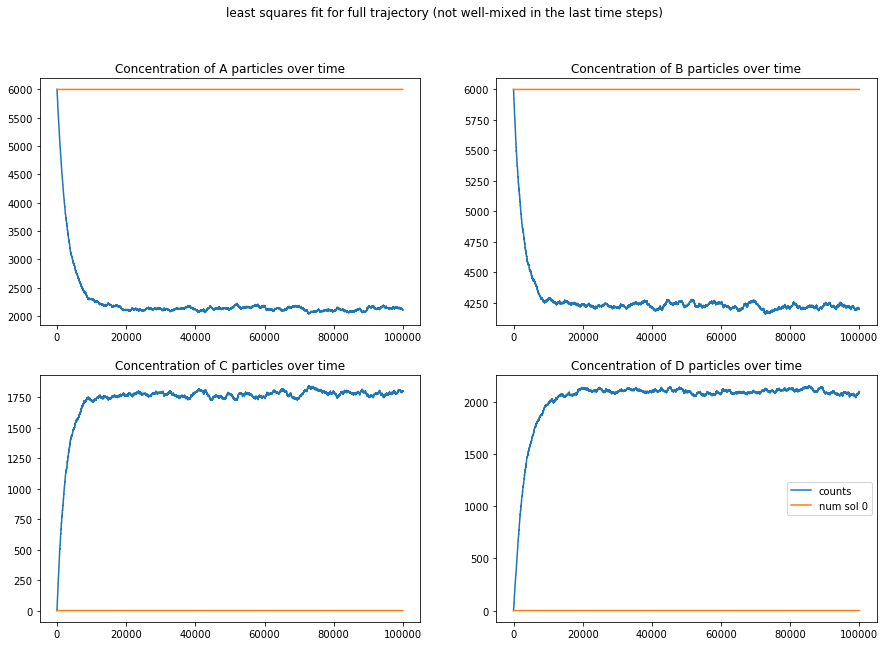

In [38]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
for _, coeffs in coefficients:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps)))
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(0, full_traj.n_time_steps), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()